<a href="https://colab.research.google.com/github/carpetmat/Project4/blob/master/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4

## **ATTENTION!**
Please read the instructions below, before running the code.

This project requires Obspy to be installed, which for colab **requires** the runtime to be restarted afterwards. This is not set up to run in juypter notebook at the moment. However this is taken care of automatically in the cell below as it forces a runtime reset. But I do not know of a way to run a cell automatically after doing this. Thus you will need to:


<h1>Run the below cell <b>twice</b>.<h1>

Or run it once, then "run all" afterwards. That works too I guess. Or just "run all" twice, you do you!

In [3]:
#This will check if Obspy is installed, and if not, install it and automatically reset the runtime.
import pathlib
file = pathlib.Path('/usr/local/lib/python3.6/dist-packages/obspy')
if file.exists ():
  print ('Obspy installed, runtime reset. You are clear to proceed.')
  from obspy.core import read, Stream, Trace, UTCDateTime
  import numpy as np
  import matplotlib.pyplot as plt
  import math as M
  from matplotlib import mlab
  from matplotlib.colors import Normalize
  import requests
  from lxml import html
  from scipy import signal
  import matplotlib.colors as colors
  import datetime
  from scipy.fftpack import fft
else:
  import time, os, sys
  print ('Obspy needed, please wait while Obspy is installed...')
  save_stdout = sys.stdout
  sys.stdout = open('trash', 'w')
  !pip install obspy
  sys.stdout = save_stdout
  time.sleep(1)
  print ('Install complete, resetting runtime')
  print('Please run code again.')
  time.sleep(1)
  os.kill(os.getpid(), 9)

#This can also be used to find file path, if obspy location is different.
# !pip list --path | grep obspy

Obspy installed, runtime reset. You are clear to proceed.


## **My Functions**

---



In [0]:
def Data_Slicer(url):
  xfft_Final = np.array([])
  st = read(url)
  fs = st[0].stats.sampling_rate
  Total_Time = M.ceil(st[0].stats.endtime - st[0].stats.starttime)
  for One_Sec in range(1,5):
    t_seg_start = st[0].stats.starttime + One_Sec - 1
    if One_Sec >= st[0].stats.endtime:
      t_seg_end = st[0].stats.endtime
    else:
      t_seg_end = st[0].stats.starttime + One_Sec
    sliced = st.slice(t_seg_start, t_seg_end)
    x = (sliced[0].data)*np.hanning(len(sliced[0].data))
    xfft = np.array(2*np.square(fft(x,64000))/(len(x)*fs))
    if One_Sec == 1:
      xfft_Final = xfft
    else:
      xfft_Final += xfft
  xfft_Final= xfft_Final/Total_Time
  data_db = 10*np.log10(np.abs(xfft_Final))+169-128.9
  # st[0].stats
  # st[0].plot()
  # fre = np.linspace(1,fs,64000)
  # plt.plot(fre[0:32000], data_db[0:32000],label='PSD')
  # plt.xlabel('frequency [Hz]')
  # plt.ylabel('PSD [dB/Hz]')
  # plt.xlim(0,200)

  return data_db

In [0]:
#This function exclusivley plots the average data. Cause I didn't want to clutter my other function.
def Plot_Data(URL_List, Profiler_Name):

  print('Processing data for wind and rain')
  Rain_Wind = Data_Slicer(URL_List[0])
  print('Processing data for only wind')
  Only_Wind = Data_Slicer(URL_List[1])
  print('Processing data for only rain')
  Only_Rain = Data_Slicer(URL_List[2])
  print('Processing data for no wind and rain')
  No_Rain_Wind = Data_Slicer(URL_List[3])
  print('Plotting results...')
  fs = 64000 #I know, it's bad form, but oh well. Time is limited.
  fre = np.linspace(1,fs,64000)

  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[20,10], gridspec_kw={'hspace': 0, 'wspace': 0.1})
  fig.suptitle(f'Wind and Rain Sound Energy for {Profiler_Name}', y=0.95, fontsize=30)

  #Left
  ax1.plot(fre[0:32000],Rain_Wind[0:32000], c='#7300AD', label='Both Wind and Rain')
  ax1.plot(fre[0:32000],No_Rain_Wind[0:32000], c='#BEAAC8', label='No Wind nor Rain')
  ax1.set_title('Wind and Rain vs No Wind nor Rain')
  ax1.set(xlabel='frequency [Hz]', ylabel='PSD [dB/Hz]')
  ax1.legend(loc='upper left')
  ax1.tick_params(axis='both',gridOn=True)
  ax1.set_xlim([0, 25000])

  #Right
  ax2.plot(fre[0:32000],Only_Wind[0:32000], c='r', label='Only Wind')
  ax2.plot(fre[0:32000],Only_Rain[0:32000], c='b', label='Only Rain')
  ax2.set_title('Wind vs Rain')
  ax2.set(xlabel='frequency [Hz]', ylabel='PSD [dB/Hz]')
  ax2.legend(loc='upper left')
  ax2.tick_params(axis='both',gridOn=True)
  ax2.set_xlim([0, 25000])

In [0]:
def Plot_Spectrogram(url, Starting_time = 0, Time_Range = 1, \
                     nfft_Divisor = 32, per_lap = 0.90, freq_min = 0, \
                     freq_max = 25000, Vmin = 0, Vmax = 120, level = 30):
  
  """Pulls data from the provided url, and processes the fft and PSD vs time and frequency

  Arg:
      url: data file url link
      Starting_time: What second the spectrogram starts from, relative time. 0 Default. (It starts at the very beginning).
      Time_Range: How many seconds you want to analyze in total begging from starting time. Default 1. (It only looks at 1 second of data).
      nfft_Divisor: Helps determin the number of fft points of each bin, higher means lower nfft. Default 32
      per_lap: Percentage of overlap. Default 0.9 (90%).
      freq_min: Mininum frequency displayed, in Hz. Default 0.
      freq_max: Maxinum frequency displayed, in Hz. Default 25000.
      Vmin: Idk, but it makes the colors representing dB change. Default 0.
      Vmax: Idk, but it makes the colors representing dB change. Default 120.
      level: ¯\_(ツ)_/¯ Default 30.
  Returns:
      A spectrogram
  """

  Full_Data = read(url)
  fs = Full_Data[0].stats.sampling_rate

  t_start = Full_Data[0].stats.starttime + Start
  t_end = Full_Data[0].stats.starttime + Start + Time_Range
  st = Full_Data.slice(t_start, t_end)
  npts = len(sliced[0])

  nfft = int(fs/nfft_Divisor)  # number of fft points of each bin
  nlap = int(nfft * float(per_lap))   # number of overlapped samples

  # using mlab to create the array of spectrogram 
  specgram, freq, time = mlab.specgram(st[0].data,NFFT = nfft,Fs = fs,noverlap = nlap, pad_to = None)
  specgram = 10 * np.log10(specgram) +169-128.9
  plt.contourf(time, freq, specgram, level, vmin = Vmin, vmax= Vmax)
  plt.xlabel('time (s)')
  plt.ylabel('freq (Hz)')
  plt.colorbar()
  plt.ylim(freq_min,freq_max)

## **Identifying Notable Data Ranges**


---



### Code from project 2

![Image of the code used in Project 2](https://drive.google.com/uc?id=1y54xgP5lPiyjwMXIAZbC7tRF375GcuoA)

Image [link](https://drive.google.com/file/d/1y54xgP5lPiyjwMXIAZbC7tRF375GcuoA/view?usp=sharing):

###Oregon Shelf Surface Mooring 

1.   Both rain and wind time: ~~2019-12-21 11:29:28~~, **2019-02-12 13:25:00**
  *   Rain: *2.1 mm/h*
  *   Wind: *16.0 m/s*
2.   Only wind time: **2019-02-12 08:29:13**
  *   Wind: *0.0 mm/h*
  *   Rain: *16.5 m/s*
3.   Only rain time: ~~2019-09-15 14:28:57~~, **2019-02-13 12:25**
  *   Wind: *1.5 mm/h*
  *   Rain: *0.8 m/s*
4.   No Rain and no wind time: ~~2019-06-29 02:29:30~~, **2019-02-06 23:25:00**
  *   Wind: *0.0 mm/h*
  *   Rain: 0.3 m/s

###Oregon Offshore Surface Mooring (Flux data)

1.   Both rain and wind time: ~~2019-11-26 22:29:14~~, **2019-01-04 06:05:00**
  *   Rain: *3.2 mm/h*
  *   Wind: *8.3 m/s*
2.   Only wind time: **2019-02-07 19:09:40**
  *   Wind: *0.0 mm/h*
  *   Rain: *20.6 m/s*
3.   Only rain time: ~~2019-12-21 06:29:41~~, **2019-01-20 17:05:00**
  *   Wind: *1.8 mm/h*
  *   Rain: *1.7 m/s*
4.   No rain and no wind time: ~~2019-11-13 00:29:29~~, **2019-01-30 03:05:00**
  *   Wind: *0.0 mm/h*
  *   Rain: *0.3 m/s*


### Notes in code

In [0]:
#Oregon Shelf Surface Mooring
#Both rain and wind
#2019-12-21 11:29:28 <---------No Data here. Alternative time: 2019-02-12 13:29:13 <---------Found Time: 2019-02-12T13:25:00.000015
#Only wind
#2019-02-12 08:29:13 <---------Found Time: 2019-02-12T08:25:00.000015
#Only rain
#2019-09-15 14:28:57 <---------No Data here. Alternative time: 2019-02-13 12:29:13 <---------Found Time: 2019-02-13T12:25:00.000015
#No Rain and no wind
#2019-06-29 02:29:30 <---------Naaaaaaahhhh. Alternative time: 2019-02-06 23:29:13 <---------Found Time: 2019-02-06T23:25:00.000000


#Oregon Offshore Surface Mooring
#Both rain and wind
#2019-11-26 22:29:14 <---------No Data here. Alternative time: 2019-01-04 06:09:19 <---------Found Time: 2019-01-04T06:05:00.000000
#Only wind
#2019-02-07 19:09:40 <---------Found Time: 2019-02-07T19:05:00.000015
#Only rain
#2019-12-21 06:29:41 <---------No Data here. Alternative time: 2019-01-20 17:09:44 <---------Found Time: 2019-01-20T17:05:00.000000
#No Rain and no wind
#2019-11-13 00:29:29 <---------No Data here. Alternative time: 2019-01-30 03:09:43 <---------Found Time: 2019-01-30T03:05:00.000000

## **URL Listings**


---



### [Oregon Shelf Cabled Benthic Experiment Package Data](https://ooinet.oceanobservatories.org/data_access/?search=CE02SHBP-LJ01D-11-HYDBBA106)
(Oregon Shelf Surface Mooring data comparison)

In [0]:
OSC_Rain_and_Wind_URL = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2019/02/12/OO-HYEA2--YDH-2019-02-12T13:25:00.000015.mseed'
OSC_Only_Wind_URL = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2019/02/12/OO-HYEA2--YDH-2019-02-12T08:25:00.000015.mseed'
OSC_Only_Rain_URL = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2019/02/13/OO-HYEA2--YDH-2019-02-13T12:25:00.000015.mseed'
OSC_No_Rain_nor_Wind_URL = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2019/02/06/OO-HYEA2--YDH-2019-02-06T23:25:00.000000.mseed'
OSC_URL_List = [OSC_Rain_and_Wind_URL, OSC_Only_Wind_URL, OSC_Only_Rain_URL, OSC_No_Rain_nor_Wind_URL]
OSC_Name= 'Oregon Shelf Cabled'

### [Oregon Offshore Cabled Benthic Experiment Package Data](https://ooinet.oceanobservatories.org/data_access/?search=CE04OSBP-LJ01C-11-HYDBBA105)
(Oregon Offshore Surface Mooring data comparison)

In [0]:
OOC_Rain_and_Wind_URL = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/01/04/OO-HYEA1--YDH-2019-01-04T06:05:00.000000.mseed'
OOC_Only_Wind_URL = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/02/07/OO-HYEA1--YDH-2019-02-07T19:05:00.000015.mseed'
OOC_Only_Rain_URL = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/01/20/OO-HYEA1--YDH-2019-01-20T17:05:00.000000.mseed'
OOC_No_Rain_nor_Wind_URL = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/01/30/OO-HYEA1--YDH-2019-01-30T03:05:00.000000.mseed'
OOC_URL_List = [OOC_Rain_and_Wind_URL, OOC_Only_Wind_URL, OOC_Only_Rain_URL, OOC_No_Rain_nor_Wind_URL]
OOC_Name= 'Oregon Offshore Cabled'

## **Data Analysis**

---



Processing data for wind and rain
Processing data for only wind
Processing data for only rain
Processing data for no wind and rain
Plotting results...


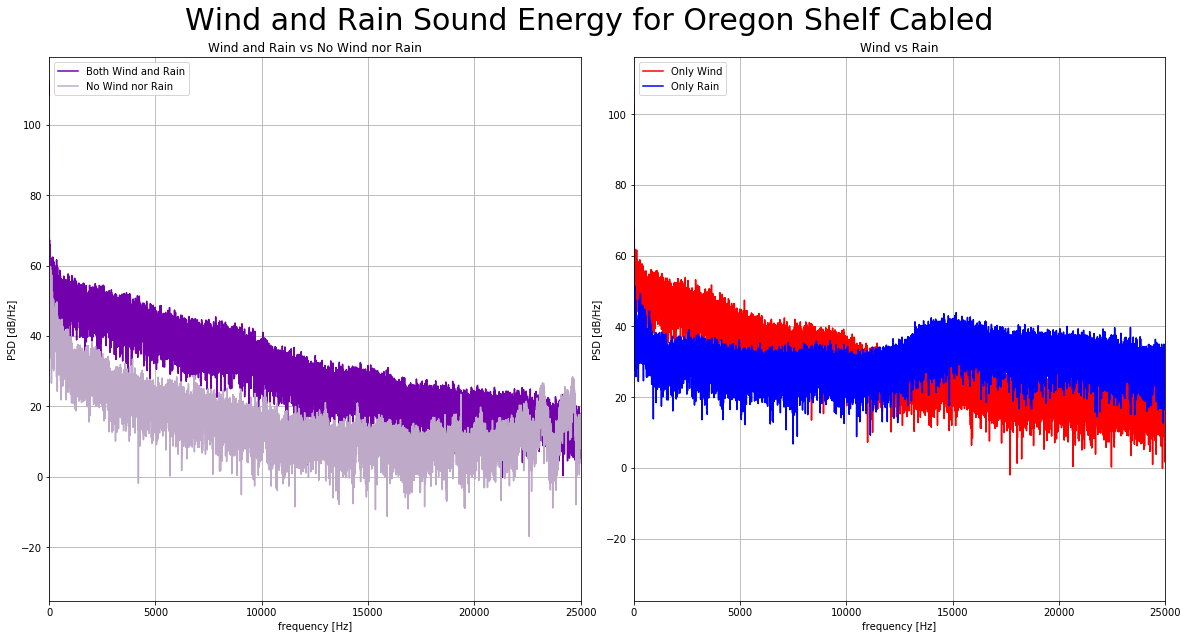

In [52]:
Plot_Data(OSC_URL_List,OSC_Name)

Processing data for wind and rain
Processing data for only wind
Processing data for only rain
Processing data for no wind and rain
Plotting results...


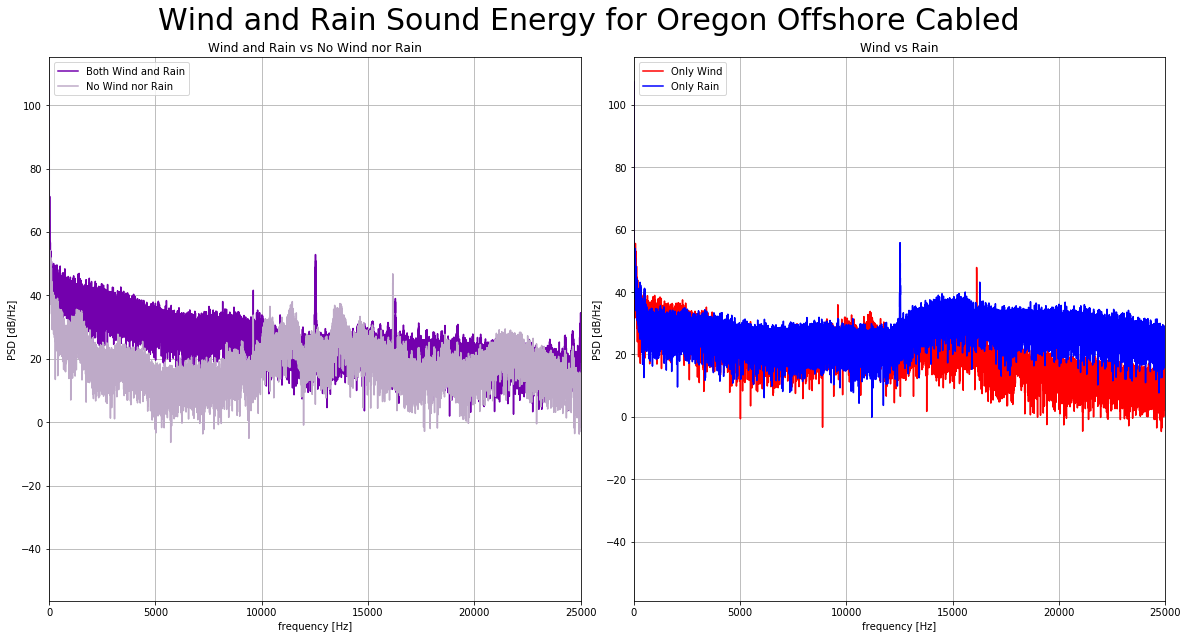

In [53]:
Plot_Data(OOC_URL_List,OOC_Name)

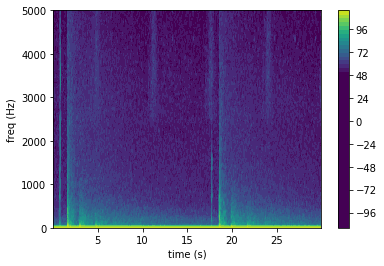

In [132]:
Airgun_url ='https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2019/08/01/OO-AXVM1--YDH-2019-08-01T00:00:00.000015.mseed'
Plot_Spectrogram(test_url, Starting_time=12, Time_Range=30, freq_max=5000, level=60, Vmin= 50, Vmax= 120)

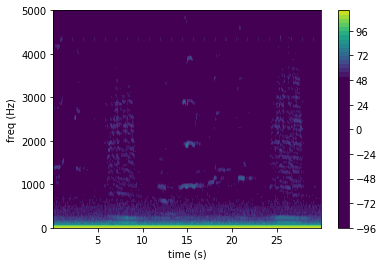

In [141]:
Mammals_url ='https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T20:00:00.000015.mseed'
Plot_Spectrogram(Mammals_url, Starting_time=0, Time_Range=30, freq_max=5000, level=60, Vmin= 50, Vmax= 120)

Mag 5.3 Earthquake at 2019-06-22 13:00:14, not too far away from axial seamount


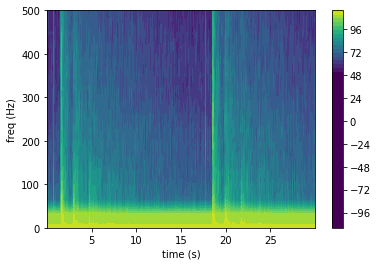

In [142]:
print('Mag 5.3 Earthquake at 2019-06-22 13:00:14, not too far away from axial seamount')
Earthquake_url ='https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2019/06/02/OO-AXVM1--YDH-2019-06-02T13:00:00.000000.mseed'
Plot_Spectrogram(test_url, Starting_time=0, Time_Range=30, freq_max=500, level=60, Vmin= 50, Vmax= 120)